## This is the k-nearest neighbors workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement k-nearest neighbors.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with the data, training and evaluating a simple classifier, k-fold cross validation, and as a Python refresher.

## Import the appropriate libraries

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from utils.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [37]:
# Set the path to the CIFAR-10 data
cifar10_dir = 'cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


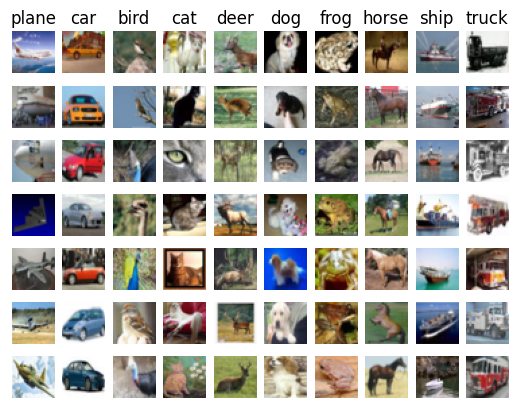

In [38]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [39]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# K-nearest neighbors

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [19]:
# Import the KNN class

from nndl import KNN

In [20]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

## Questions

(1) Describe what is going on in the function knn.train().

(2) What are the pros and cons of this training step?

## Answers

(1) `knn.train()` simply sets the instance variables of the KNN class to the training data (i.e. stores the training images and their corresponding labels).

(2) The training step is very fast because all it does is set instance variables. However, this also means that the model is storing all of the data in memory, which is very inefficient with large datasets.

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [7]:
# Implement the function compute_distances() in the KNN class.
# Do not worry about the input 'norm' for now; use the default definition of the norm
# in the code, which is the 2-norm.
# You should only have to fill out the clearly marked sections.

import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 13.604048252105713
Frobenius norm of L2 distances: 7906696.077040902


#### Really slow code

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops.

If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [8]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

Time to run code: 0.09776687622070312
Difference in L2 distances between your KNN implementations (should be 0): 0.0


#### Speedup

Depending on your computer speed, you should see a 10-100x speed up from vectorization.  On our computer, the vectorized form took 0.36 seconds while the naive implementation took 38.3 seconds. 

### Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [9]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

error = 1

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the error rate by calling predict_labels on the test 
#   data with k = 1.  Store the error rate in the variable error.
# ================================================================ #

y_pred = knn.predict_labels(dists_L2, k=1)
error = np.sum(y_pred != y_test) / num_test

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print(error)

0.726


If you implemented this correctly, the error should be: 0.726.

This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great, considering that chance levels are 10%.

# Optimizing KNN hyperparameters

In this section, we'll take the KNN classifier that you have constructed and perform cross-validation to choose a best value of $k$, as well as a best choice of norm.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [31]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# ================================================================ #
# YOUR CODE HERE:
#   Split the training data into num_folds (i.e., 5) folds.
#   X_train_folds is a list, where X_train_folds[i] contains the 
#      data points in fold i.
#   y_train_folds is also a list, where y_train_folds[i] contains
#      the corresponding labels for the data in X_train_folds[i]
# ================================================================ #

np.random.seed(1)

shuffled = np.random.permutation(num_training)
X_train_shuffled = X_train[shuffled]
y_train_shuffled = y_train[shuffled]
fold_size = num_training // num_folds

for i in range(num_folds):
    X_train_folds.append(X_train_shuffled[i*fold_size:(i+1)*fold_size])
    y_train_folds.append(y_train_shuffled[i*fold_size:(i+1)*fold_size])

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #



### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

In [32]:
time_start =time.time()

ks = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the cross-validation error for each k in ks, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of k vs. cross-validation error. Since 
#   we are assuming L2 distance here, please use the vectorized code!
#   Otherwise, you might be waiting a long time.
# ================================================================ #

ks_errors = []
for k in ks:
    print(f'Evaluating k={k}...')
    k_errors = []
    for i in range(num_folds):
        X_val, y_val = X_train_folds[i], y_train_folds[i]
        X_train_cv = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        y_train_cv = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        
        knn.train(X_train_cv, y_train_cv)
        dists = knn.compute_L2_distances_vectorized(X=X_val)

        y_pred = knn.predict_labels(dists, k=k)
        error = np.sum(y_pred != y_val) / fold_size
        k_errors.append(error)
    ks_errors.append(np.mean(k_errors))

k_opt = ks[np.argmin(ks_errors)]
print(f'Best value of k: {k_opt} (error = {min(ks_errors)})')
        
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Computation time: %.2f'%(time.time()-time_start))

Evaluating k=1...
Evaluating k=2...
Evaluating k=3...
Evaluating k=5...
Evaluating k=7...
Evaluating k=10...
Evaluating k=15...
Evaluating k=20...
Evaluating k=25...
Evaluating k=30...
Best value of k: 5 (error = 0.727)
Computation time: 16.75


Text(0.5, 1.0, 'Optimizing hyperparameter $k$')

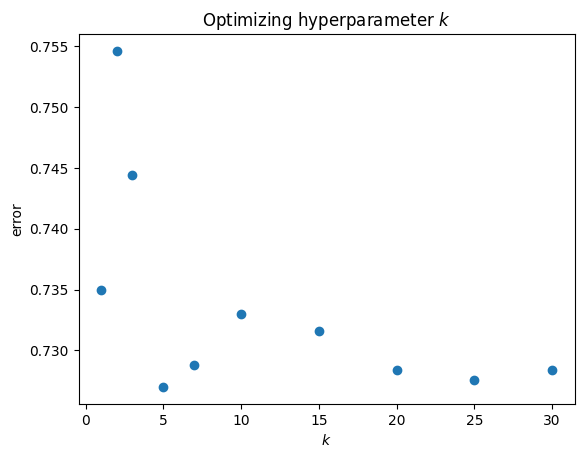

In [33]:
plt.scatter(ks, ks_errors)
plt.xlabel('$k$')
plt.ylabel('error')
plt.title('Optimizing hyperparameter $k$')

## Questions:

(1) What value of $k$ is best amongst the tested $k$'s?

(2) What is the cross-validation error for this value of $k$?

## Answers:

(1) $k = 5$ is the best value among the tested $k$'s.

(2) The cross-validation error for $k = 5$ is 0.727.

### Optimizing the norm

Next, we test three different norms (the 1, 2, and infinity norms) and see which distance metric results in the best cross-validation performance.

In [34]:
time_start =time.time()

L1_norm = lambda x: np.linalg.norm(x, ord=1)
L2_norm = lambda x: np.linalg.norm(x, ord=2)
Linf_norm = lambda x: np.linalg.norm(x, ord= np.inf)
norms = [L1_norm, L2_norm, Linf_norm]

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the cross-validation error for each norm in norms, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of the norm used vs the cross-validation error
#   Use the best cross-validation k from the previous part.  
#
#   Feel free to use the compute_distances function.  We're testing just
#   three norms, but be advised that this could still take some time.
#   You're welcome to write a vectorized form of the L1- and Linf- norms
#   to speed this up, but it is not necessary.
# ================================================================ #

norms_errors = []
for i, norm in enumerate(norms):
    print(f'Evaluating norm #{i+1}...')
    norm_errors = []
    for i in range(num_folds):
        X_cv_test, y_cv_test = X_train_folds[i], y_train_folds[i]
        X_cv_train = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        y_cv_train = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])

        knn.train(X_cv_train, y_cv_train)
        dists = knn.compute_distances(X=X_cv_test, norm=norm)

        y_pred = knn.predict_labels(dists, k=k_opt)
        error = np.sum(y_pred != y_cv_test) / fold_size
        norm_errors.append(error)
    norms_errors.append(np.mean(norm_errors))

i_opt = np.argmin(norms_errors)
print(f'Best norm: norm #{i_opt+1} (error = {norms_errors[i_opt]})')

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
print('Computation time: %.2f'%(time.time()-time_start))

Evaluating norm #1...
Evaluating norm #2...
Evaluating norm #3...
Best norm: norm #1 (error = 0.7051999999999999)
Computation time: 269.35


Text(0.5, 1.0, 'Optimizing hyperparameter norm')

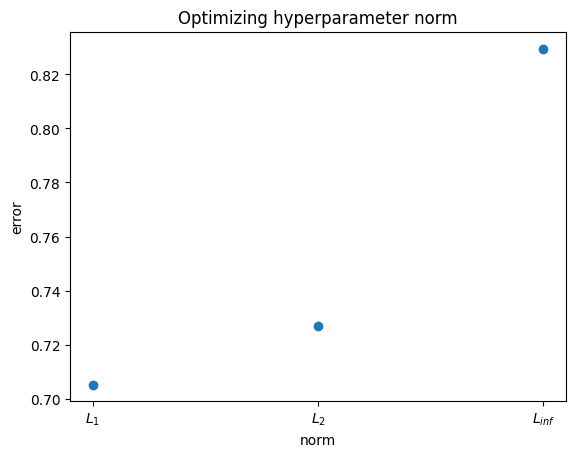

In [35]:
norm_labels = ['$L_1$', '$L_2$', '$L_{inf}$']
plt.xticks(np.arange(3), norm_labels)
plt.scatter(norm_labels, norms_errors)
plt.xlabel('norm')
plt.ylabel('error')
plt.title('Optimizing hyperparameter norm')

## Questions:

(1) What norm has the best cross-validation error?

(2) What is the cross-validation error for your given norm and k?

## Answers: 

(1) The L1-norm has the best cross-validation error.

(2) The cross-validation error for the L1-norm with $k = 5$ is about 0.705.

# Evaluating the model on the testing dataset.

Now, given the optimal $k$ and norm you found in earlier parts, evaluate the testing error of the k-nearest neighbors model.

In [40]:
error = 1

# ================================================================ #
# YOUR CODE HERE:
#   Evaluate the testing error of the k-nearest neighbors classifier
#   for your optimal hyperparameters found by 5-fold cross-validation.
# ================================================================ #

knn.train(X_train, y_train)
dists_L1 = knn.compute_distances(X=X_test, norm=L1_norm)
y_pred = knn.predict_labels(dists_L1, k=k_opt)
error = np.sum(y_pred != y_test) / num_test

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Error rate achieved: {}'.format(error))

Error rate achieved: 0.7


## Question:

How much did your error improve by cross-validation over naively choosing $k=1$ and using the L2-norm?

## Answer:

My error improved from 0.726 to 0.7, a difference of 0.026.